# Experiments with hidden states

Question, is there a better representation of concepts in hidden states?

Setup: we use DPO setup, with a chosen and rejected string. We then generate a set of hidden states, and compare the hidden states of the chosen and rejected string.

Goal: better generalisation of desired behavuour by changing the internal representation of policy rather than directly changing the policy

  - Hypothesis: rejected and chosen hidden states will - on mean - be best representated as rotations from each other
  - alternate: either mean mass diff (linear) or no repr will be better
  - metric: manual generation getting output while maintaining coherency, prediction other sets of hs

In [104]:
%reload_ext autoreload
%autoreload 2

In [105]:
import numpy as np

from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import DPOTrainer
from trl import DPOConfig, DPOTrainer

import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
from einops import rearrange

from pathlib import Path

from reprpo.helpers.adapters import set_adapter
from einops import rearrange
from matplotlib import pyplot as plt
from reprpo import silence
from reprpo.gen import generation_test

from reprpo.trainer import mean_with_attention, symlog, mult_with_attention

from tqdm.auto import tqdm
from einops import reduce
from reprpo.trainer import collect_hs, ReprPOConfig, ReprPOTrainer, normalize_output, normalize_per
from reprpo.helpers.shypothesis import shypothesis
from datasets import load_dataset

## Load model

In [3]:
from reprpo.models.load import load_model, print_trainable_parameters
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
model_name = "NousResearch/Meta-Llama-3-8B-Instruct"

## Big adapter
peft_config = LoraConfig(
    lora_alpha=16, 
    r=16,
    lora_dropout=0.0,
    use_rslora=False,
    # use_dora=True,
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)


model, tokenizer = load_model(model_name, )
# from trl.trainer.utils import peft_module_casting_to_bf16
# peft_module_casting_to_bf16(model)
adapter_name='ReprPO2'
model = prepare_model_for_kbit_training(model, {'use_gradient_checkpointing': True})
model = get_peft_model(model, peft_config, adapter_name=adapter_name)
print_trainable_parameters(model)
# model

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 41943040 || all params: 4582543360 || trainable%: 0.9152786281546499


## Load adapter

In [4]:
dpo_adapter_f = './output-dir/dpo/DPO'
model.load_adapter(dpo_adapter_f, 'DPO')

_IncompatibleKeys(missing_keys=['base_model.model.model.embed_tokens.weight', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.ReprPO2.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.ReprPO2.weight', 'base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_A.ReprPO2.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_B.ReprPO2.weight', 'base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_A.ReprPO2.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_B.ReprPO2.weight', 'base_model.model.model.layers.0.self_attn.o_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_A.ReprPO2.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_B.ReprPO2.weight', 'base_model.model.model.layers.0.mlp.gate_proj.bas

In [5]:
# # QC model and adapter is coherent
# generation_test(model, tokenizer, max_new_tokens=24, system='no yapping', adapter_names=[None, 'DPO'])

## Load DPO dataset

In [6]:
num_samples = 160

In [7]:
def sample(dataset, N):
    return (dataset
            .shuffle(42)
            .select(range(
            min(len(dataset),
                N)))
    )

dataset = load_dataset('Atsunori/HelpSteer2-DPO')
dataset['train'] = sample(dataset['train'], num_samples)
dataset['validation'] = sample(dataset['validation'], num_samples)
dataset2 = dataset.rename_column('chosen_response', 'chosen').rename_column('rejected_response', 'rejected')
dataset2

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 160
    })
    validation: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 160
    })
})

## Helpers

## Collect HS in DPO way

In [10]:
training_args = ReprPOConfig('./output-dir/scratch',
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    gradient_checkpointing=True,
    bf16=True,
    tf32=True,
    max_prompt_length=128,
    max_length=256,
    collection_layers=[10, 20]
                             )
reprpo_trainer = ReprPOTrainer(
    model=model,
    ref_model=None,
    args=training_args,
    beta=training_args.beta,
    train_dataset=dataset2["train"],
    # eval_dataset=dataset2["test"],
    tokenizer=tokenizer,
)

/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/trl/trainer/dpo_trainer.py:442: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(


In [11]:
# QC get dpo catch
dl = reprpo_trainer.get_train_dataloader()
batch = next(iter(dl))
batch['chosen_input_ids'].shape

torch.Size([6, 256])

In [12]:
# QC view a typical input to the model (since the dpo trainer transformes in dataset, concatenating chosen and rejecting along the batch dimension)
batch_concat = reprpo_trainer.concatenated_inputs(
            batch,
            is_encoder_decoder=reprpo_trainer.is_encoder_decoder,
            label_pad_token_id=reprpo_trainer.label_pad_token_id,
            padding_value=reprpo_trainer.padding_value,
            device=reprpo_trainer.accelerator.device,
            max_length=reprpo_trainer.args.max_length,
        )
layer_idx = 0
print(batch_concat.keys())
batch['chosen_input_ids'].shape, batch_concat['concatenated_input_ids'].shape

dict_keys(['concatenated_input_ids', 'concatenated_attention_mask', 'concatenated_labels'])


(torch.Size([6, 256]), torch.Size([12, 256]))

In [15]:
# get batch of hidden states
from reprpo.helpers.torch import clear_mem
from trl.trainer.utils import pad_to_length
from torch import Tensor
from jaxtyping import Float

def get_batch_token_logits(
    logits: torch.FloatTensor,
    labels: torch.LongTensor,
    label_pad_token_id: int = -100,
    is_encoder_decoder: bool = False,
) -> Tuple[torch.FloatTensor, torch.LongTensor]:
    """Collect label logits (no softmax)

    Args:
        logits: Logits of the model (unnormalized). Shape: (batch_size, sequence_length, vocab_size)
        labels: Labels for which to compute the log probabilities. Label tokens with a value of label_pad_token_id are ignored. Shape: (batch_size, sequence_length)
        label_pad_token_id: The label pad token id.
        is_encoder_decoder: Whether the model is an encoder-decoder model.

    Returns:
        A Tuple of two tensor of shape ((batch_size,), (batch_size,)) containing the logits of the given labels under the given logits in the first tensor and the number of non-masked tokens in the second tensor.
    """
    if logits.shape[:-1] != labels.shape:
        raise ValueError(
            "Logits (batch and sequence length dim) and labels must have the same shape."
        )

    if not is_encoder_decoder:
        labels = labels[:, 1:].clone()
        logits = logits[:, :-1, :]
    loss_mask = labels != label_pad_token_id

    # dummy token; we'll ignore the losses on these tokens later
    labels[labels == label_pad_token_id] = 0

    per_token_logits = torch.gather(
        logits, dim=2, index=labels.unsqueeze(2)
    ).squeeze(2)

    # so this multiplies the probs and makes it quite small, in the log domain that's ok, it represents the log probs of the whole string
    return (per_token_logits * loss_mask).sum(-1), loss_mask.sum(-1)

@torch.no_grad()
def get_hs(trainer, model, batch):
    model.eval()
    (
        chosen_logps,
        rejected_logps,
        chosen_logits,
        rejected_logits,
        _,
        chosen_hs,
        rejected_hs,
        chosen_attn_mask,
        rejected_attn_mask
    ) = trainer.concatenated_forward(trainer.model, batch)

    r = dict(chosen_hs=chosen_hs, rejected_hs=rejected_hs, chosen_logps=chosen_logps, rejected_logps=rejected_logps, chosen_attn_mask=chosen_attn_mask, rejected_attn_mask=rejected_attn_mask)

    # get unembected hs
    r['chosen_unemb'] = model.lm_head(chosen_hs)
    r['rejected_unemb'] = model.lm_head(rejected_hs)


    # FIXME: label and logits are diff length, maybe need the padding from concat_batch, might be eaiser to just use the concat batch framework for both
    def get_layer_logps(trainer, hidden_states: Float[Tensor, 'b l t h'], labels: Float[Tensor, 'b t'], log_softmax=True):
        # pad to length
        hidden_states = pad_to_length(hidden_states, trainer.max_length, pad_value=0)
        labels = pad_to_length(labels, trainer.max_length, pad_value=trainer.label_pad_token_id)

        # gather for each layer
        logps = []
        for layer in range(hidden_states.shape[1]):
            all_logps, size_completion = trainer.get_batch_logps(
                hidden_states[:, layer],
                labels,
                label_pad_token_id=trainer.label_pad_token_id,
                log_softmax=log_softmax
                )
            all_logps = all_logps / size_completion
            logps.append(all_logps)
        all_logps = torch.stack(logps, dim=1)
        return all_logps
    
    # get fake logp from unemb_hs
    r['chosen_gthr_logps_unemb'] = get_layer_logps(trainer, r['chosen_unemb'], batch["chosen_labels"])
    r['rejection_gthr_logps_unemb'] = get_layer_logps(trainer, r['rejected_unemb'], batch["rejected_labels"])

    r['chosen_gthr_unemb'] = get_layer_logps(trainer, r['chosen_unemb'], batch["chosen_labels"], log_softmax=False)
    r['rejection_gthr_unemb'] = get_layer_logps(trainer, r['rejected_unemb'], batch["rejected_labels"], log_softmax=False)
    
    # we reuse the function, adding a fake layer dim, and squeezing it out
    r['chosen_gthr_logits'] = get_layer_logps(trainer, chosen_logits[:, None], batch["chosen_labels"], log_softmax=False).squeeze(1)
    r['rejected_gthr_logits'] = get_layer_logps(trainer, rejected_logits[:, None], batch["rejected_labels"], log_softmax=False).squeeze(1)


    r = {k: v.detach().cpu() for k, v in r.items()}
    clear_mem(trainer)
    
    return r

In [16]:
dl = reprpo_trainer.get_train_dataloader()

data = []
for i, batch in enumerate(tqdm(dl)):
    with reprpo_trainer.null_ref_context():
        r = get_hs(reprpo_trainer, reprpo_trainer.model, batch)
        data.append(r)
        if i > 2:
            break

# concat
data = {k: torch.cat([d[k] for d in data], dim=0) for k in data[0].keys()}
data['chosen_hs'].shape

  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([24, 2, 256, 4096])

In [17]:
model = None
clear_mem(reprpo_trainer)
reprpo_trainer = None
clear_mem()

In [18]:
list(data.keys())

['chosen_hs',
 'rejected_hs',
 'chosen_logps',
 'rejected_logps',
 'chosen_attn_mask',
 'rejected_attn_mask',
 'chosen_unemb',
 'rejected_unemb',
 'chosen_gthr_logps_unemb',
 'rejection_gthr_logps_unemb',
 'chosen_gthr_unemb',
 'rejection_gthr_unemb',
 'chosen_gthr_logits',
 'rejected_gthr_logits']

## Get samples

In [283]:
# get some data samples
layer = 1
C = data['chosen_hs'] # we could also consider unembedding them, whith the lm head, this might make them more interpretable, but also a bit large
R = data['rejected_hs']

CA = data['chosen_attn_mask']
RA = data['rejected_attn_mask']

M = 100
A2 = CA * RA # use both attn masks when comparing?

# choose layer, mean over tokens
C = mult_with_attention(C, A2)[:M, layer]
C = reduce(C, 'b t h -> b h', 'mean')
R = mult_with_attention(R, A2)[:M, layer]
R = reduce(R, 'b t h -> b h', 'mean')

# compare two unrelated sets of samples, that way we have ones that should show the difference and ones that shouldn't show the difference we arel ooking for
n = len(C)//2
print('n', n)
C1 = C[:n] # chosen pair 1
R1 = R[:n] # rejected pair 1
C2 = C[n:] # chosen, pair 2
R2 = R[n:] # rejected pair 2


# now we choose what to test correlations with. At first I tried the logprobs but they have been through a softmax which makes them relative and hard to compare to the hidden states
# so instead we are going to try the hidden states values that corresponded to the 

# logratios = data['chosen_logps'] - data['rejected_logps'] # the logp is the log probability (mean per token) of this response, logratios is the log ratio of probs, this should be correlated with the direction we are seeking in the hidden states

# logratios = (data['chosen_gthr_logits'] - data['rejected_gthr_logits'])#.exp()
logratios = data['chosen_gthr_unemb'][:, layer] - data['rejection_gthr_unemb'][:, layer]

# we can use this to check the null hypothesis, as the `roll` operation mixes up the batch dimension, so they are unrelated
logratios_unrelated = logratios.roll(1, 0)

logratios1 = logratios[:n]
logratios2 = logratios[n:]
logratios2

## Hypothesis

### Magnitude/norm is correlated with result?

Is the amplitude of A-B related to the logp?

In [310]:
# logratios

In [284]:
# ur using abs corrcoef
def acorr(A, B):
    return np.abs(np.corrcoef(A, B, rowvar=True)[0, 1])

def mag_corr(C, R, logratios):
    hs_d = torch.norm(C-R, dim=-1, p=2) # get magnitude of the difference
    corr = acorr(hs_d, logratios)
    # note that after flipping we ruin the order, and they should be uncorrelated except for the middle one if it's odd
    corr_null = acorr(hs_d, logratios.roll(1, 0))
    return corr, corr_null
    

print('does the magnitude of the hs_unemb correlate with the prob ratio (across batches)? if so it\'s a good repr')

print("should be significantly bigger")
corr, corr_null = mag_corr(C1, R1, logratios1)
shypothesis("corr>corr_null", variables=dict(corr=corr, corr_null=corr_null))

print("should pass")
corr, corr_null = mag_corr(C2, R2, logratios2)
shypothesis("corr>corr_null", variables=dict(corr=corr, corr_null=corr_null))

does the magnitude of the hs_unemb correlate with the prob ratio (across batches)? if so it's a good repr
should be significantly bigger
Hypothesis: corr>corr_null
          : 0.082 > 0.083
Residual  : = corr - corr_null
Residual  : = 0.0 ❌

should pass
Hypothesis: corr>corr_null
          : 0.589 > 0.309
Residual  : = corr - corr_null
Residual  : = 0.280 ✅



#### Is it significant?

is the red line outside the distribution of null correlations?


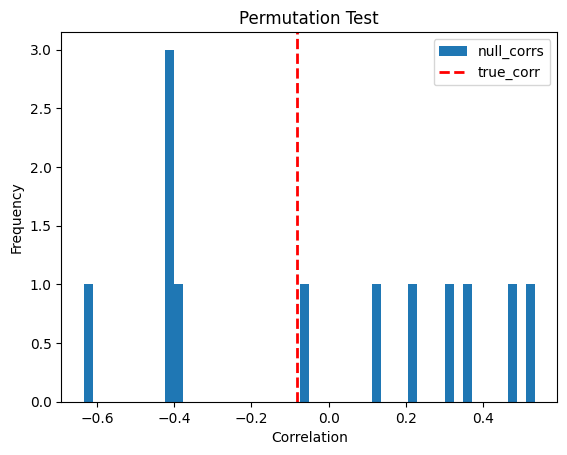

P-value: 0.923


In [312]:
def permutation_test(C, R, logratios, n_permutations=100):

    n_permutations = min(n_permutations, len(logratios))

    true_corr = np.corrcoef(
        torch.norm(C - R, dim=-1, p=2), 
        logratios)[0, 1]
    
    null_corrs = []
    for _ in range(n_permutations):
        perm_logratios = logratios[torch.randperm(len(logratios))]
        null_corrs.append(np.corrcoef(torch.norm(C - R, dim=-1, p=2), perm_logratios)[0, 1])
    
    plt.hist(null_corrs, bins=50, label='null_corrs')
    plt.axvline(true_corr, color='r', linestyle='dashed', linewidth=2, label='true_corr')
    plt.title('Permutation Test')
    plt.xlabel('Correlation')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    p_value = (np.sum(np.abs(null_corrs) >= np.abs(true_corr)) + 1) / (n_permutations + 1)
    print(f"P-value: {p_value:.3f}")

print('is the red line outside the distribution of null correlations?')
permutation_test(C1, R1, logratios1)
# FAIL

### spearmanr kendalltau

In [286]:
import numpy as np

In [313]:
from scipy import stats


def correlation_dist(C, R, logratios):
    distances = torch.norm(C - R, dim=-1)
    logratios = logratios.cpu().numpy()
    corr, p = stats.spearmanr(distances, logratios)
    return np.abs(corr), p

print('spearmanr measure of dist ~ logratios should be large and significant')
corr, p = correlation_dist(C1, R1, logratios1)
n_corr, n_p = correlation_dist(C1, R1, logratios1.roll(1, 0))
shypothesis('corr>n_corr', variables=locals())
shypothesis('p<0.2', variables=locals())

def kendalltau_dist(C, R, logratios):
    distances = torch.norm(C - R, dim=-1)
    logratios = logratios.cpu().numpy()
    corr, p = stats.kendalltau(distances, logratios)
    return np.abs(corr), p

print('kendalltau measure of dist ~ logratios should be large and significant')
corr, p = kendalltau_dist(C1, R1, logratios1)
n_corr, n_p = kendalltau_dist(C1, R1, logratios1.roll(1, 0))
shypothesis('corr>n_corr', variables=locals())
shypothesis('p<0.2', variables=locals())
shypothesis('n_p<0.2', variables=locals())

spearmanr measure of dist ~ logratios should be large and significant
Hypothesis: corr>n_corr
          : 0.105 > 0.077
Residual  : = corr - n_corr
Residual  : = 0.028 ✅

Hypothesis: p<0.2
          : 0.746 < 0.200
Residual  : = p - 0.2
Residual  : = 0.546 ❌

kendalltau measure of dist ~ logratios should be large and significant
Hypothesis: corr>n_corr
          : 0.061 > 0.091
Residual  : = corr - n_corr
Residual  : = -0.030 ❌

Hypothesis: p<0.2
          : 0.841 < 0.200
Residual  : = p - 0.2
Residual  : = 0.641 ❌

Hypothesis: n_p<0.2
          : 0.737 < 0.200
Residual  : = n_p - 0.2
Residual  : = 0.537 ❌



In [315]:
import torch
import torch.nn.functional as F
import numpy as np

def angle_similarity_correlation(C, R, logratios):
    C_norm = F.normalize(C, p=2, dim=-1)
    R_norm = F.normalize(R, p=2, dim=-1)
    angle = torch.acos(torch.clamp(torch.sum(C_norm * R_norm, dim=-1), -1.0, 1.0))
    corrs = np.corrcoef(angle.cpu().numpy(), logratios.cpu().numpy())[0, 1]
    return np.abs(corrs)

def norm_difference_correlation(C, R, logratios):
    norm_diff = torch.norm(C, dim=-1) - torch.norm(R, dim=-1)
    corrs = np.corrcoef(norm_diff.cpu().numpy(), logratios.cpu().numpy())[0, 1]
    return np.abs(corrs)

def magnitude_correlation(C, R, logratios):
    magnitude_diff = torch.abs(C - R).mean(dim=-1)
    corrs = np.corrcoef(magnitude_diff.cpu().numpy(), logratios.cpu().numpy())[0, 1]
    return np.abs(corrs)

def inner_product_correlation(C, R, logratios):
    inner_prod = torch.sum(C * R, dim=-1)
    corrs = np.corrcoef(inner_prod.cpu().numpy(), logratios.cpu().numpy())[0, 1]
    return np.abs(corrs)

# Usage
def run_all_tests(C1, R1, C2, R2, logratios1, logratios2):
    tests = [
        angle_similarity_correlation,
        norm_difference_correlation,
        magnitude_correlation,
        inner_product_correlation
    ]
    
    for test in tests:
        print(f"\nTesting {test.__name__}:")
        c111 = test(C1, R1, logratios1)
        c222 = test(C2, R2, logratios2)
        c112 = test(C1, R1, logratios1.roll(1, 0))
        c221 = test(C2, R2, logratios2.roll(1, 0))
        
        print('Similarity of related ones should be higher')
        shypothesis('c111 > c112', variables=locals(), verbose=True)
        shypothesis('c222 > c221', variables=locals())
        # Uncomment these if you want to test across different pairs
        # shypothesis('c111 > c221', variables=locals())
        # shypothesis('c222 > c112', variables=locals())

# Run all tests
run_all_tests(C1, R1, C2, R2, logratios1, logratios2)


Testing angle_similarity_correlation:
Similarity of related ones should be higher
Hypothesis: c111 > c112
          : c111 > c112
     Where: {'c111': 0.17653066864825379, 'c112': 0.06311316313647669}
          : 0.177 > 0.063
Residual  : = c111 - c112
Residual  : = 0.113 ✅

Hypothesis: c222 > c221
          : 0.642 > 0.290
Residual  : = -c221 + c222
Residual  : = 0.351 ✅


Testing norm_difference_correlation:
Similarity of related ones should be higher
Hypothesis: c111 > c112
          : c111 > c112
     Where: {'c111': 0.18184877604691557, 'c112': 0.13933448014055647}
          : 0.182 > 0.139
Residual  : = c111 - c112
Residual  : = 0.043 ✅

Hypothesis: c222 > c221
          : 0.340 > 0.268
Residual  : = -c221 + c222
Residual  : = 0.072 ✅


Testing magnitude_correlation:
Similarity of related ones should be higher
Hypothesis: c111 > c112
          : c111 > c112
     Where: {'c111': 0.09435227364063753, 'c112': 0.09191347777559443}
          : 0.094 > 0.092
Residual  : = c111 - c112


### H: cosine_similarity_correlation

In [314]:
def cosine_similarity_correlation(C, R, logratios):
    cos_sim = F.cosine_similarity(C, R, dim=-1)  # [batch, layers, tokens]

    corrs = np.corrcoef(cos_sim, logratios)[0, 1] 
    
    return np.abs(corrs)

c111 = cosine_similarity_correlation(C1, R1, logratios1)
c222 = cosine_similarity_correlation(C2, R2, logratios2)
c112 = cosine_similarity_correlation(C1, R1, logratios1.roll(1, 0))
c221 = cosine_similarity_correlation(C2, R2, logratios2.roll(1, 0))

print('cosine similarity of related ones should be higher')
shypothesis('c111 > c112', variables=locals(), verbose=True)
shypothesis('c222 > c221', variables=locals())
# shypothesis('c111 > c221', variables=locals())
# shypothesis('c222 > c112', variables=locals())

cosine similarity of related ones should be higher
Hypothesis: c111 > c112
          : c111 > c112
     Where: {'c111': 0.19708932282301475, 'c112': 0.052489255910791635}
          : 0.197 > 0.052
Residual  : = c111 - c112
Residual  : = 0.145 ✅

Hypothesis: c222 > c221
          : 0.575 > 0.367
Residual  : = -c221 + c222
Residual  : = 0.207 ✅



In [318]:
def kl_divergence(p, q):
    return (p * (p / q).log()).sum(dim=-1)

def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

def mutual_information(C, R):
    joint = torch.einsum('bt,bt->bt', C, R)
    joint = joint / joint.sum(dim=-1, keepdim=True)
    mi = kl_divergence(joint, C * R)
    return mi

def info_theoretic_correlation(C, R, logratios):
    C_norm = F.softmax(C, dim=-1)
    R_norm = F.softmax(R, dim=-1)
    
    kl = kl_divergence(C_norm, R_norm)#.mean(dim=(1,))
    js = js_divergence(C_norm, R_norm)#.mean(dim=(1,))
    mi = mutual_information(C_norm, R_norm)#.mean(dim=(1,))
    
    kl_corr = np.abs(np.corrcoef(kl.cpu().numpy(), logratios)[0,1])
    js_corr = np.abs(np.corrcoef(js.cpu().numpy(), logratios)[0,1])
    mi_corr = np.abs(np.corrcoef(mi.cpu().numpy(), logratios)[0,1])
    
    return kl_corr, js_corr, mi_corr

print("C1-R1 with logratios1:")
kl1,js1,mi1 = info_theoretic_correlation(C1, R1, logratios1)
kl2,js2,mi1 = info_theoretic_correlation(C1, R1, logratios1.roll(1, 0))
shypothesis('kl1>kl2', variables=locals())
shypothesis('js1>js2', variables=locals())
shypothesis('mi1>mi2', variables=locals())

print("C2-R2 with logratios2:")
kl1,js1,mi1 = info_theoretic_correlation(C2, R2, logratios2)
kl2,js2,mi1 = info_theoretic_correlation(C2, R2, logratios2.roll(1, 0))
shypothesis('kl1>kl2', variables=locals())
shypothesis('js1>js2', variables=locals())
shypothesis('mi1>mi2', variables=locals())

C1-R1 with logratios1:
Hypothesis: kl1>kl2
          : 0.004 > 0.115
Residual  : = kl1 - kl2
Residual  : = -0.111 ❌

Hypothesis: js1>js2
          : 0.006 > 0.115
Residual  : = js1 - js2
Residual  : = -0.109 ❌

Hypothesis: mi1>mi2
          : 0.449 > 0
Residual  : = mi1 - mi2
Residual  : = 0.449 ✅

C2-R2 with logratios2:
Hypothesis: kl1>kl2
          : 0.134 > 0.410
Residual  : = kl1 - kl2
Residual  : = -0.276 ❌

Hypothesis: js1>js2
          : 0.103 > 0.409
Residual  : = js1 - js2
Residual  : = -0.307 ❌

Hypothesis: mi1>mi2
          : 0.164 > 0
Residual  : = mi1 - mi2
Residual  : = 0.164 ✅



In [291]:
@torch.no_grad()
def rotation_test(C, R, logratios):
    def optimal_rotation(A, B):

        corr_matrix = torch.mm(A.t(), B)
        Q, _ = torch.linalg.qr(corr_matrix)
        return Q
    
    def optimal_rotation(A, B):
        corr_matrix = torch.mm(A.t(), B)
        U, _, V = torch.linalg.svd(corr_matrix)
        return torch.mm(U, V.t())
    
    R_opt = optimal_rotation(C, R)
    R_rotated = torch.matmul(R, R_opt.t())
    
    a = C - R
    b = C - R_rotated

    # a -= a.mean(dim=-1, keepdim=True)
    # b -= b.mean(dim=-1, keepdim=True)
    # a /= torch.norm(a, dim=0, p=2, keepdim=True)
    # b /= torch.norm(b, dim=0, p=2, keepdim=True)

    original_diff = torch.norm(a, p=2)
    rotated_diff = torch.norm(b, p=2)
    
    print(f"Original difference: {original_diff}")
    print(f"Rotated difference: {rotated_diff}")
    print(f"Improvement: {(original_diff - rotated_diff) / original_diff * 100:.2f}%")
    
    c = np.abs(np.corrcoef(torch.norm(a, dim=-1, p=2), logratios)[0, 1])
    r = np.abs(np.corrcoef(torch.norm(b, dim=-1, p=2), logratios)[0, 1])
    print(f"Correlation before rotation: {c:.2f}")
    print(f"Correlation after rotation: {r:.2f}")
    print(f"Improvement: {(r - c) / c * 100:.2f}%")
    print()
    shypothesis('r > c', variables=dict(r=r, c=c))
    return R_opt, R_rotated

# maybe I should softmax first?
R_opt, R_rotated = rotation_test(C1, R1, logratios1)
R_opt, R_rotated = rotation_test(C2, R2, logratios2)

R_opt, R_rotated = rotation_test(C2, R2, logratios2.roll(1, 0))
R_opt, R_rotated = rotation_test(C1, R1, logratios1.roll(1, 0))
# R_opt, R_rotated = rotation_test(C2, R2, logratios1)
# R_opt, R_rotated = rotation_test(C1, R1, logratios2)

Original difference: 5.040531635284424
Rotated difference: 29.78263282775879
Improvement: -490.86%
Correlation before rotation: 0.08
Correlation after rotation: 0.06
Improvement: -21.15%

Hypothesis: r > c
          : 0.065 > 0.082
Residual  : = -c + r
Residual  : = -0.017 ❌

Original difference: 5.16802978515625
Rotated difference: 27.767431259155273
Improvement: -437.29%
Correlation before rotation: 0.59
Correlation after rotation: 0.02
Improvement: -96.05%

Hypothesis: r > c
          : 0.023 > 0.589
Residual  : = -c + r
Residual  : = -0.566 ❌

Original difference: 5.16802978515625
Rotated difference: 27.767431259155273
Improvement: -437.29%
Correlation before rotation: 0.31
Correlation after rotation: 0.13
Improvement: -56.57%

Hypothesis: r > c
          : 0.134 > 0.309
Residual  : = -c + r
Residual  : = -0.175 ❌

Original difference: 5.040531635284424
Rotated difference: 29.78263282775879
Improvement: -490.86%
Correlation before rotation: 0.08
Correlation after rotation: 0.22
Imp

### Principal Component Analysis (PCA):
Apply PCA to (A - B) pairs. If differences are primarily rotational, most variance should be explained by a few components.

In [292]:
from sklearn.decomposition import PCA

def pca_exp_var(X, Y):
    diffs = (X - Y).numpy()
    s = diffs.std()
    diffs /= s
    # axis 1, norm each neuron across the batch
    # diffs /= diffs.std(1, keepdims=True) + 1e-3
    pca = PCA(n_components=5)
    pca.fit(diffs)
    r = pca.explained_variance_ratio_.mean()
    return r


# 
e_a1b1 = pca_exp_var(C1, R1)
e_a1b1roll = pca_exp_var(C1, R1.roll(1, 0))
shypothesis('e_a1b1 > e_a1b1roll', variables=locals())

e_a1b1 = pca_exp_var(C2, R2)
e_a1b1roll = pca_exp_var(C2, R2.roll(1, 0))
shypothesis('e_a1b1 > e_a1b1roll', variables=locals())

# e_a1a2 = pca_exp_var(C1, C2)
# e_a1b2 = pca_exp_var(C1, R2)
# e_b1b2 = pca_exp_var(R1, R2)
# e_b1a1 = pca_exp_var(R1, C1)
# e_b1a2 = pca_exp_var(R1, C2)

# print('PCA explained variance ratio')
# print('A1-B1', e_a1b2)
# shypothesis('e_a1b1 > e_a1a2', variables=locals())
# shypothesis('e_a1b1 > e_a1b2', variables=locals())
# shypothesis('e_a1b1 > e_b1b2', variables=locals()) # should be inconclusive
# e_a1b2, e_a1a2, e_a1b2, e_b1b2

Hypothesis: e_a1b1 > e_a1b1roll
          : 0.163 > 0.170
Residual  : = e_a1b1 - e_a1b1roll
Residual  : = -0.007 ❌

Hypothesis: e_a1b1 > e_a1b1roll
          : 0.150 > 0.157
Residual  : = e_a1b1 - e_a1b1roll
Residual  : = -0.008 ❌



## mutual_information

In [293]:
from sklearn.feature_selection import mutual_info_regression

def mutual_information(C, R, logratios):
    distances = torch.norm(C - R, dim=-1, p=2, keepdim=True)
    mi = mutual_info_regression(distances, logratios)[0]
    print(f"Mutual Information: {mi}")
    return mi

print('do the paired hs have information shared with the logratios?')
mi1 = mutual_information(C1, R1, logratios1)
mi2 = mutual_information(C1, R1, logratios1.roll(1, 0));
shypothesis('mi1 > mi2', variables=locals())

do the paired hs have information shared with the logratios?
Mutual Information: 0.09186808561808668
Mutual Information: 0
Hypothesis: mi1 > mi2
          : 0.092 > 0
Residual  : = mi1 - mi2
Residual  : = 0.092 ✅



### Frobenius Norm Comparison:
Compare ||A - B||_F with ||A - RB||_F where R is the optimal rotation. The latter should be significantly smaller if rotations capture most differences.

In [294]:
def norm_comparison(A, B):
    diff_norm = torch.norm(A - B)
    corr = torch.mm(A, B.t())
    U, _, V = torch.svd(corr)
    R = torch.mm(U, V.t())

    B_rot = torch.mm(R, B)

    rot_diff_norm = torch.norm(A - B_rot)
    return diff_norm, rot_diff_norm

print('passing means the paired samples can be rotated')
diff_norm, rot_diff_norm= norm_comparison(C1, R1)
shypothesis('rot_diff_norm < diff_norm', variables=locals())

print('passing means the paired samples can be rotated')
diff_norm, rot_diff_norm= norm_comparison(C2, R2)
# print(diff_norm, rot_diff_norm)
shypothesis('rot_diff_norm < diff_norm', variables=locals())

print('passing means the unrelated samples can be rotated')
diff_norm, rot_diff_norm= norm_comparison(C1, R2)
shypothesis('rot_diff_norm > diff_norm', variables=locals())

print('passing means the unrelated samples can be rotated')
diff_norm, rot_diff_norm= norm_comparison(C2, R1)
# print(diff_norm, rot_diff_norm)
shypothesis('rot_diff_norm > diff_norm', variables=locals())

# UNEEXPECTED result: C and R are already in a similar direction! While unrelated ones are not
# this implies that the preference concept that we want is not a factor of directions of the hidden states, but rather the magnitude of the difference between the two

passing means the paired samples can be rotated
Hypothesis: rot_diff_norm < diff_norm
          : 4.886 < 5.041
Residual  : = -diff_norm + rot_diff_norm
Residual  : = -0.154 ✅

passing means the paired samples can be rotated
Hypothesis: rot_diff_norm < diff_norm
          : 5.017 < 5.168
Residual  : = -diff_norm + rot_diff_norm
Residual  : = -0.151 ✅

passing means the unrelated samples can be rotated
Hypothesis: rot_diff_norm > diff_norm
          : 12.650 > 14.921
Residual  : = -diff_norm + rot_diff_norm
Residual  : = -2.271 ❌

passing means the unrelated samples can be rotated
Hypothesis: rot_diff_norm > diff_norm
          : 12.882 > 15.115
Residual  : = -diff_norm + rot_diff_norm
Residual  : = -2.233 ❌



In [295]:
print('are the magnitudes related?')
c_norms = torch.norm(C1, dim=-1)
r_norms = torch.norm(R1, dim=-1)
norm_diffs = c_norms - r_norms
corr1 = np.abs(np.corrcoef(norm_diffs.flatten(), logratios1)[0, 1])
print(f"Correlation of norm differences with logratios: {corr:.2f}")



c_norms = torch.norm(C1, dim=-1)
r_norms = torch.norm(R1, dim=-1)
norm_diffs = c_norms - r_norms
corr2 = np.abs(np.corrcoef(norm_diffs.flatten(), logratios2)[0, 1])
print(f"Correlation of norm differences with logratios: {corr:.2f}")

shypothesis('corr1 > corr2', variables=locals())

are the magnitudes related?
Correlation of norm differences with logratios: 0.06
Correlation of norm differences with logratios: 0.06
Hypothesis: corr1 > corr2
          : 0.182 > 0.097
Residual  : = corr1 - corr2
Residual  : = 0.085 ✅



In [296]:
diff_norm, rot_diff_norm= norm_comparison(C1, R2)
diff_norm, rot_diff_norm

(tensor(14.9215), tensor(12.6504))

Angle Histogram:
Plot histogram of angles between corresponding columns of A and B. Should be concentrated if differences are mainly rotational.

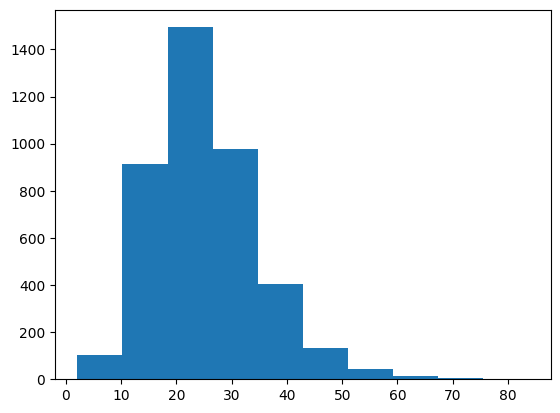

In [297]:
def angle_histogram(A, B):
    cos_sims = torch.sum(A * B, dim=0) / (torch.norm(A, dim=0) * torch.norm(B, dim=0))
    angles = torch.acos(cos_sims) * 180 / np.pi
    plt.hist(angles.numpy())
    plt.show()

angle_histogram(C1, R1)

In [298]:
def subspace_scaling(C, R, n_subspaces=10):
    pca = PCA(n_components=n_subspaces)
    pca.fit(np.vstack((C.reshape(-1, C.shape[-1]), R.reshape(-1, R.shape[-1]))))
    c_proj = pca.transform(C.reshape(-1, C.shape[-1]))
    r_proj = pca.transform(R.reshape(-1, R.shape[-1]))
    scale_ratios = np.linalg.norm(c_proj, axis=0) / np.linalg.norm(r_proj, axis=0)
    return scale_ratios

scales = subspace_scaling(C1, R1)
print("Subspace scaling ratios:", scales)

scales = subspace_scaling(C1, R2)
print("Subspace scaling ratios:", scales)

# ??
corr

Subspace scaling ratios: [1.02573366 0.95217523 0.96733044 0.92265209 0.89132623 0.95582475
 0.9571119  0.95361726 0.99413921 0.95186764]
Subspace scaling ratios: [1.73066033 1.74128314 1.01378417 0.58045075 3.24369333 1.12954028
 0.97207083 1.32819393 1.60161157 1.01987266]


0.0606060606060606

In [299]:
def sparsity_correlation(C, R, logratios):
    c_sparsity = (np.abs(C) > 1e-2).float().mean(dim=-1)
    r_sparsity = (np.abs(R) > 1e-2).float().mean(dim=-1)
    sparsity_diff = c_sparsity - r_sparsity
    corr = np.corrcoef(sparsity_diff.flatten(), logratios)[0, 1]
    print(f"Correlation of sparsity differences with logratios: {corr}")
    return np.abs(corr)

c111 = sparsity_correlation(C1, R1, logratios1)
c222 = sparsity_correlation(C2, R2, logratios2)

print('unrelated, should be null results')
c112 = sparsity_correlation(C1, R1, logratios2)
c221 = sparsity_correlation(C2, R2, logratios1)

shypothesis('c111 > c112', variables=locals())
shypothesis('c222 > c221', variables=locals())
shypothesis('c111 > c112', variables=locals())
shypothesis('c222 > c221', variables=locals())

# !!! SUCCESS

Correlation of sparsity differences with logratios: -0.004424094892843868
Correlation of sparsity differences with logratios: 0.14424148271708376
unrelated, should be null results
Correlation of sparsity differences with logratios: -0.2868185883775725
Correlation of sparsity differences with logratios: 0.06892329032083197
Hypothesis: c111 > c112
          : 0.004 > 0.287
Residual  : = c111 - c112
Residual  : = -0.282 ❌

Hypothesis: c222 > c221
          : 0.144 > 0.069
Residual  : = -c221 + c222
Residual  : = 0.075 ✅

Hypothesis: c111 > c112
          : 0.004 > 0.287
Residual  : = c111 - c112
Residual  : = -0.282 ❌

Hypothesis: c222 > c221
          : 0.144 > 0.069
Residual  : = -c221 + c222
Residual  : = 0.075 ✅



In [300]:
from scipy.fft import fft

def fft_analysis(C, R):
    C_fft = fft(C.cpu().numpy(), axis=-1)
    R_fft = fft(R.cpu().numpy(), axis=-1)
    return C_fft - R_fft

def fft_corr(C, R, logratios):
    fft_diff = fft_analysis(C, R)
    fft_norm = np.linalg.norm(fft_diff, axis=-1)
    fft_corr = np.abs(np.corrcoef(fft_norm, logratios)[0,1])
    return fft_corr

c1 = fft_corr(C1, R1, logratios1)
c1n = fft_corr(C1, R1, logratios1.roll(1, 0))
shypothesis('c1 > c1n', variables=locals(), verbose=True)

c2 = fft_corr(C2, R2, logratios2)
c2n = fft_corr(C2, R2, logratios2.roll(1, 0))
shypothesis('c2 > c2n', variables=locals())

Hypothesis: c1 > c1n
          : c1 > c1n
     Where: {'c1': 0.08233526961650646, 'c1n': 0.08276932002069595}
          : 0.082 > 0.083
Residual  : = c1 - c1n
Residual  : = 0.0 ❌

Hypothesis: c2 > c2n
          : 0.589 > 0.309
Residual  : = c2 - c2n
Residual  : = 0.280 ✅



In [301]:

def non_lin_corr(C, R, logratios):
    C = symlog(C)
    R = symlog(R)
    nl_diff = C - R
    nl_norm = torch.norm(nl_diff, dim=-1)
    nl_corr = np.corrcoef(nl_norm, logratios)[0,1]
    corr_null = np.corrcoef(nl_norm, logratios.roll(1,0))[0,1]
    shypothesis('abs(nl_corr) > abs(corr_null)', variables=locals(), verbose=True)

print('are the right pairs more correlate if we take the diff of the symlog?')
non_lin_corr(C1, R1, logratios1)
non_lin_corr(C2, R2, logratios2)
# but it's the same result without symlog...

are the right pairs more correlate if we take the diff of the symlog?
Hypothesis: abs(nl_corr) > abs(corr_null)
          : Abs(nl_corr) > Abs(corr_null)
     Where: {'corr_null': -0.10750608919582604, 'nl_corr': -0.05941568343201138}
          : 0.059 > 0.108
Residual  : = -Abs(corr_null) + Abs(nl_corr)
Residual  : = -0.048 ❌

Hypothesis: abs(nl_corr) > abs(corr_null)
          : Abs(nl_corr) > Abs(corr_null)
     Where: {'corr_null': 0.1945450034581702, 'nl_corr': 0.6174599443322354}
          : 0.617 > 0.195
Residual  : = -Abs(corr_null) + Abs(nl_corr)
Residual  : = 0.423 ✅



In [302]:
def relative_positioning(C, R, ref_point):
    C_rel = C - ref_point
    R_rel = R - ref_point
    return torch.norm(C_rel, dim=-1) - torch.norm(R_rel, dim=-1)

# Using mean of C2 as reference point
ref_point = C2.mean(dim=(0), keepdim=True)
rel_diff = relative_positioning(C1, R1, ref_point)
rel_corr = np.abs(np.corrcoef(rel_diff.flatten(), logratios1)[0,1])
rel_corr2 = np.abs(np.corrcoef(rel_diff.flatten(), logratios1.roll(1, 0))[0,1])
shypothesis('rel_corr > rel_corr2', variables=locals())

Hypothesis: rel_corr > rel_corr2
          : 0.015 > 0.275
Residual  : = rel_corr - rel_corr2
Residual  : = -0.261 ❌



In [303]:
def cosine_similarity(a, b):
    return F.cosine_similarity(a, b, dim=-1)

c1r1_sim = cosine_similarity(C1, R1)
c2r2_sim = cosine_similarity(C2, R2)

c1r1_sim_corr = np.corrcoef(c1r1_sim.flatten(), logratios1)[0,1]
c2r2_sim_corr = np.corrcoef(c2r2_sim.flatten(), logratios2)[0,1]
c1r1null_sim_corr = np.corrcoef(c1r1_sim.flatten(), logratios1.roll(1, 0))[0,1]
c2r2null_sim_corr = np.corrcoef(c2r2_sim.flatten(), logratios2.roll(1, 0))[0,1]
shypothesis('c1r1_sim_corr > c1r1null_sim_corr', variables=locals())
shypothesis('c2r2_sim_corr > c2r2null_sim_corr', variables=locals())

print(f"C1-R1 similarity correlation with logratio: {c1r1_sim_corr}")
print(f"C2-R2 similarity correlation with logratio: {c2r2_sim_corr}")

Hypothesis: c1r1_sim_corr > c1r1null_sim_corr
          : 0.197 > -0.052
Residual  : = c1r1_sim_corr - c1r1null_sim_corr
Residual  : = 0.250 ✅

Hypothesis: c2r2_sim_corr > c2r2null_sim_corr
          : -0.575 > -0.367
Residual  : = c2r2_sim_corr - c2r2null_sim_corr
Residual  : = -0.207 ❌

C1-R1 similarity correlation with logratio: 0.19708932282301475
C2-R2 similarity correlation with logratio: -0.5745852117123851


In [304]:
def global_position(x, global_mean):
    return F.cosine_similarity(x - global_mean, global_mean, dim=-1)

global_mean = torch.cat([C1, R1, C2, R2], dim=0).mean(dim=(0), keepdim=True)

def glob_pos_corr(C, R, logratios):
    c_global = global_position(C, global_mean)
    r_global = global_position(R, global_mean)
    global_diff = c_global - r_global
    global_corr = np.corrcoef(global_diff.flatten(), logratios)[0,1]
    return np.abs(global_corr)

print('if we project hs onto the global mean then correlate...')
c1 = glob_pos_corr(C1, R1, logratios1)
c2 = glob_pos_corr(C2, R2, logratios2)
c3n = glob_pos_corr(C1, R1, logratios1.roll(1, 0))
c4n = glob_pos_corr(C2, R2, logratios2.roll(1, 0))
shypothesis('c1 > c3n', variables=locals())
shypothesis('c2 > c4n', variables=locals())

if we project hs onto the global mean then correlate...
Hypothesis: c1 > c3n
          : 0.168 > 0.298
Residual  : = c1 - c3n
Residual  : = -0.130 ❌

Hypothesis: c2 > c4n
          : 0.425 > 0.236
Residual  : = c2 - c4n
Residual  : = 0.189 ✅



In [305]:
def relative_position(a, b, ref):
    a_rel = F.cosine_similarity(a - ref, ref, dim=-1)
    b_rel = F.cosine_similarity(b - ref, ref, dim=-1)
    return a_rel - b_rel

# Use C2 mean as reference
def rel_pos_corr(C1, R1, C2, logratios1):
    ref = C2.mean(dim=(0), keepdim=True)
    rel_pos1 = relative_position(C1, R1, ref)
    rel_pos_corr = np.abs(np.corrcoef(rel_pos1.flatten(), logratios1)[0,1])
    return rel_pos_corr

c1 = rel_pos_corr(C1, R1, C2, logratios1)
c2 = rel_pos_corr(C2, R2, C1, logratios2)
c3n = rel_pos_corr(C1, R1, C2, logratios1.roll(1, 0))
c4n = rel_pos_corr(C2, R2, C1, logratios2.roll(1, 0))
shypothesis('c1 > c3n', variables=locals())
shypothesis('c2 > c4n', variables=locals())
print(f"Relative position correlation: {c1}")
print(f"Relative position correlation (null): {c2}")

Hypothesis: c1 > c3n
          : 0.164 > 0.268
Residual  : = c1 - c3n
Residual  : = -0.104 ❌

Hypothesis: c2 > c4n
          : 0.410 > 0.228
Residual  : = c2 - c4n
Residual  : = 0.182 ✅

Relative position correlation: 0.16419729238550518
Relative position correlation (null): 0.41037309139761635


In [306]:
def projection_correlation(C, R, logratios):
    # Compute the mean difference vector
    mean_diff = (C - R).mean(dim=0)

    # Project samples onto this direction
    c_proj = F.cosine_similarity(C, mean_diff.unsqueeze(0), dim=-1)
    r_proj = F.cosine_similarity(R, mean_diff.unsqueeze(0), dim=-1)
    proj_diff = c_proj - r_proj

    proj_corr = np.abs(np.corrcoef(proj_diff, logratios)[0,1])
    return proj_corr

proj_corr1 = projection_correlation(C1, R1, logratios1)
print(f"Preference direction projection correlation: {proj_corr1}")

proj_corr2 = projection_correlation(C2, R2, logratios2)
print(f"Preference direction projection correlation: {proj_corr2}")

proj_corr3 = projection_correlation(C2, R2, logratios2.roll(1, 0))
print(f"Preference direction projection correlation: {proj_corr3}")


proj_corr4 = projection_correlation(C1, R1, logratios1.roll(1, 0))
print(f"Preference direction projection correlation: {proj_corr4}")

shypothesis('proj_corr1 > proj_corr4', variables=locals())
shypothesis('proj_corr2 > proj_corr3', variables=locals())


Preference direction projection correlation: 0.14460565238170017
Preference direction projection correlation: 0.5432624445982506
Preference direction projection correlation: 0.2423268342820158
Preference direction projection correlation: 0.17629937077085425
Hypothesis: proj_corr1 > proj_corr4
          : 0.145 > 0.176
Residual  : = proj_corr1 - proj_corr4
Residual  : = -0.032 ❌

Hypothesis: proj_corr2 > proj_corr3
          : 0.543 > 0.242
Residual  : = proj_corr2 - proj_corr3
Residual  : = 0.301 ✅



In [307]:
def var_corr(C, R, logratios):
    c_var = C.var(dim=-1)
    r_var = R.var(dim=-1)
    var_diff = c_var - r_var

    var_corr = np.corrcoef(var_diff.flatten(), logratios)[0,1]
    return var_corr


vc0 = var_corr(C1, R1, logratios1)
print(f"Variance difference correlation: {vc0}")

vc1 = var_corr(C2, R2, logratios2)
print(f"Variance difference correlation: {vc1}")

vc2 = var_corr(C2, R2, logratios2.roll(1, 0))
print(f"Variance difference correlation: {vc2}")

vc3 = var_corr(C1, R1, logratios1.roll(1, 0))
print(f"Variance difference correlation: {vc3}")
shypothesis('abs(vc0) > abs(vc3)', variables=locals(), verbose=1)
shypothesis('abs(vc1) > abs(vc2)', variables=locals(), verbose=1)


Variance difference correlation: 0.1748688256315504
Variance difference correlation: 0.32789284950757314
Variance difference correlation: -0.29289889727162416
Variance difference correlation: -0.06691499025422101
Hypothesis: abs(vc0) > abs(vc3)
          : Abs(vc0) > Abs(vc3)
     Where: {'vc0': 0.1748688256315504, 'vc3': -0.06691499025422101}
          : 0.175 > 0.067
Residual  : = Abs(vc0) - Abs(vc3)
Residual  : = 0.108 ✅

Hypothesis: abs(vc1) > abs(vc2)
          : Abs(vc1) > Abs(vc2)
     Where: {'vc1': 0.32789284950757314, 'vc2': -0.29289889727162416}
          : 0.328 > 0.293
Residual  : = Abs(vc1) - Abs(vc2)
Residual  : = 0.035 ✅

